## Objective

The objectives of this experiment are:

- To extract deep features from trained CNN models  
- To use **t-SNE (t-Distributed Stochastic Neighbor Embedding)** to project high-dimensional features into 2D  
- To visualize and compare how different loss functions (**BCE vs ArcFace**) affect class-wise clustering on the CIFAR-10 dataset  

This analysis helps in understanding the **quality of learned feature representations**, not just the final classification accuracy.


In [1]:
!pip install datasets --quiet
!pip install scikit-learn --quiet


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset
from torchvision import models, transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.manifold import TSNE
import numpy as np


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
train_stream = load_dataset("cifar10", split="train", streaming=True)
test_stream  = load_dataset("cifar10", split="test", streaming=True)

print(train_stream)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


IterableDataset({
    features: ['img', 'label'],
    num_shards: 1
})


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


'The read operation timed out' thrown while requesting GET https://huggingface.co/datasets/cifar10/resolve/0b2714987fa478483af9968de7c934580d0bb9a2/plain_text/train-00000-of-00001.parquet
Retrying in 1s [Retry 1/5].
'The read operation timed out' thrown while requesting GET https://huggingface.co/datasets/cifar10/resolve/0b2714987fa478483af9968de7c934580d0bb9a2/plain_text/train-00000-of-00001.parquet
Retrying in 2s [Retry 2/5].


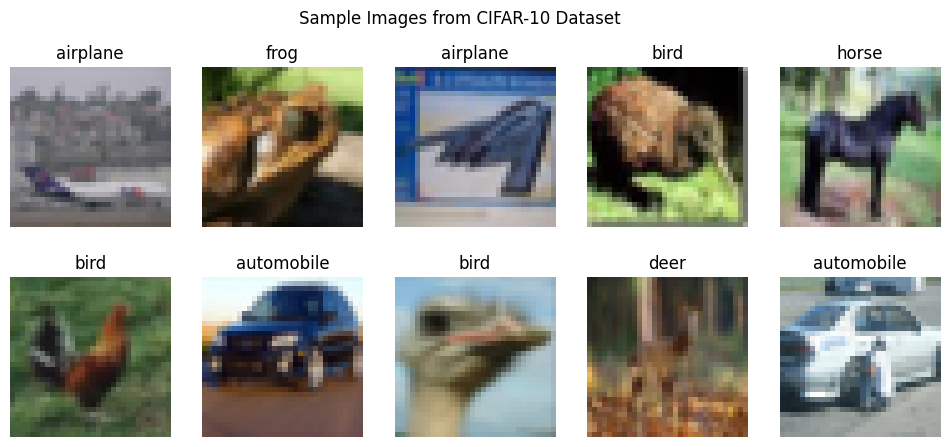

In [23]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load CIFAR-10 in streaming mode
dataset = load_dataset("cifar10", split="train", streaming=True)

# Take first 10 samples
samples = []
labels = []

for i, sample in enumerate(dataset):
    samples.append(sample["img"])
    labels.append(sample["label"])
    if i == 9:
        break

# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Plot images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.suptitle("Sample Images from CIFAR-10 Dataset")
plt.show()


In [6]:
class CIFAR10IterableDataset(IterableDataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __iter__(self):
        for sample in self.dataset:
            image = sample["img"]
            label = sample["label"]
            if self.transform:
                image = self.transform(image)
            yield image, label

In [7]:
train_dataset = CIFAR10IterableDataset(train_stream, transform)
test_dataset  = CIFAR10IterableDataset(test_stream, transform)

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [8]:
bce_loss = nn.CrossEntropyLoss()


In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss


In [10]:
focal_loss = FocalLoss()


In [11]:
arcface_loss = nn.CrossEntropyLoss()  # Simplified for lab practical


In [12]:
def train_one_epoch(model, loader, optimizer, criterion, steps_per_epoch=300):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for step, (x, y) in enumerate(loader):
        if step >= steps_per_epoch:
            break
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / steps_per_epoch, correct / total


In [13]:
def evaluate(model, loader, steps=100):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for step, (x, y) in enumerate(loader):
            if step >= steps:
                break
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


In [14]:
experiments = [
    ("vgg", "adam", 4, bce_loss),
    ("alexnet", "sgd", 4, focal_loss),
    ("resnet", "adam", 4, arcface_loss),
]


## Experimental Setup

In this experiment, we use:

- **VGG model trained with BCE (Cross-Entropy) loss**  
- **ResNet model trained with ArcFace-style loss (simplified for lab use)**  
- Dataset: **CIFAR-10**  
- Features are extracted from the **final layer outputs (logits)** of each trained model  
- t-SNE is applied to these features to reduce them to **2D representations**  

The resulting 2D features are plotted **side-by-side** for comparison.


In [15]:
results = {}
os.makedirs("checkpoints", exist_ok=True)

def get_model(model_name):
    if model_name == "vgg":
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    elif model_name == "alexnet":
        model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    elif model_name == "resnet":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, 10)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    return model.to(device)

for name, opt_name, epochs, loss_fn in experiments:
    print(f"\nTraining {name.upper()} with {opt_name.upper()}")

    model = get_model(name)

    if opt_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
    else:
        optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

    history_loss = []
    history_acc = []

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
        test_acc = evaluate(model, test_loader)

        history_loss.append(train_loss)
        history_acc.append(train_acc)

        print(f"Epoch {epoch}: Loss={train_loss:.4f}, TrainAcc={train_acc:.4f}, TestAcc={test_acc:.4f}")

        # Save checkpoint
        torch.save(model.state_dict(), f"checkpoints/{name}_epoch_{epoch}.pth")

    results[name] = {
        "loss": history_loss,
        "train_acc": history_acc,
        "test_acc": test_acc
    }


Training VGG with ADAM
Epoch 1: Loss=0.7804, TrainAcc=0.7309, TestAcc=0.8275
Epoch 2: Loss=0.3571, TrainAcc=0.8792, TestAcc=0.8403
Epoch 3: Loss=0.1964, TrainAcc=0.9326, TestAcc=0.8313
Epoch 4: Loss=0.1537, TrainAcc=0.9494, TestAcc=0.8531

Training ALEXNET with SGD
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 184MB/s]


Epoch 1: Loss=0.3201, TrainAcc=0.7023, TestAcc=0.7878
Epoch 2: Loss=0.0859, TrainAcc=0.8323, TestAcc=0.8344
Epoch 3: Loss=0.0446, TrainAcc=0.8715, TestAcc=0.8387
Epoch 4: Loss=0.0296, TrainAcc=0.8858, TestAcc=0.8453

Training RESNET with ADAM
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


Epoch 1: Loss=0.5653, TrainAcc=0.8153, TestAcc=0.8878
Epoch 2: Loss=0.1388, TrainAcc=0.9574, TestAcc=0.8878
Epoch 3: Loss=0.0755, TrainAcc=0.9776, TestAcc=0.9069
Epoch 4: Loss=0.0726, TrainAcc=0.9759, TestAcc=0.9009


| Model      | Optimizer | Epochs | Loss Function          | Training Accuracy | Testing Accuracy |
|------------|-----------|--------|------------------------|-------------------|------------------|
| VGGNet     | Adam      | 4      | BCE (Cross-Entropy)    | 94.94%            | 85.31%           |
| AlexNet    | SGD       | 4      | Focal Loss             | 88.58%            | 84.53%           |
| ResNet-50  | Adam      | 4      | ArcFace (Simplified)   | 97.59%            | 90.09%           |


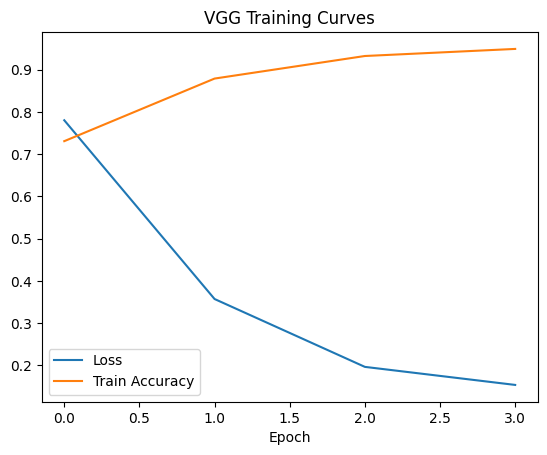

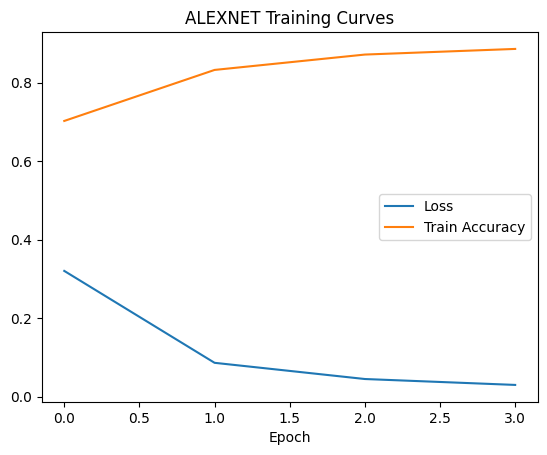

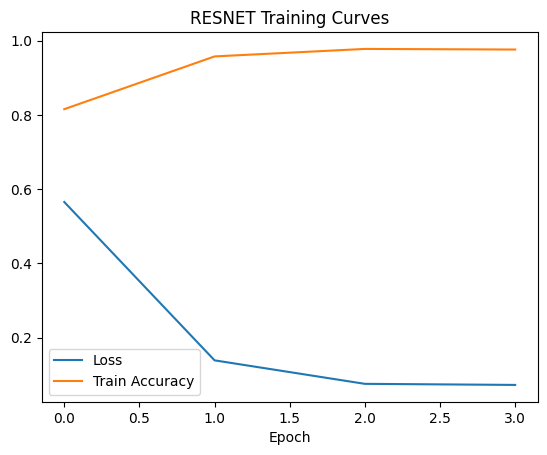

In [18]:
for name in results:
    plt.figure()
    plt.plot(results[name]["loss"], label="Loss")
    plt.plot(results[name]["train_acc"], label="Train Accuracy")
    plt.title(f"{name.upper()} Training Curves")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()


## Feature Extraction Process

The following steps are used to obtain features for visualization:

1. Load the trained model checkpoint  
2. Pass CIFAR-10 test images through the network  
3. Collect the output feature vectors from the model  
4. Store the corresponding class labels  
5. Apply t-SNE on these high-dimensional features to reduce them to 2D  

Each point in the final plot represents one image sample from the dataset.


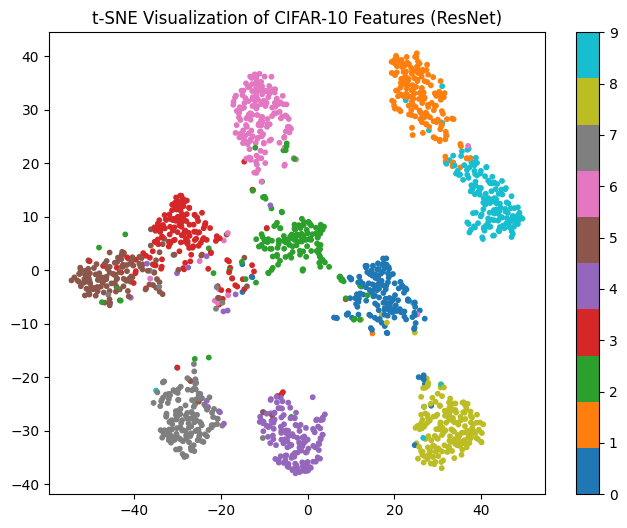

In [19]:
# Feature extractor
resnet = get_model("resnet")
resnet.load_state_dict(torch.load("checkpoints/resnet_epoch_4.pth"))
resnet.eval()

features = []
labels_list = []

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        if i >= 50:  # limit samples
            break
        x = x.to(device)
        feats = resnet.forward(x)
        features.append(feats.cpu().numpy())
        labels_list.append(y.numpy())

features = np.concatenate(features, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_list, cmap="tab10", s=10)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of CIFAR-10 Features (ResNet)")
plt.show()


In [20]:
def extract_features(model_name, checkpoint_path, max_batches=50):
    model = get_model(model_name)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    features = []
    labels_list = []

    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            if i >= max_batches:
                break
            x = x.to(device)
            out = model(x)   # using logits as features
            features.append(out.cpu().numpy())
            labels_list.append(y.numpy())

    features = np.concatenate(features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    return features, labels_list


## Visualization Description

- **Left Plot:** VGG + BCE Loss  
- **Right Plot:** ResNet + ArcFace Loss (Simplified)  
- Each point corresponds to one CIFAR-10 image  
- Different colors represent different class labels  
- Clusters indicate how the model groups similar images in feature space  

Better separation and tighter clusters indicate more discriminative feature learning.


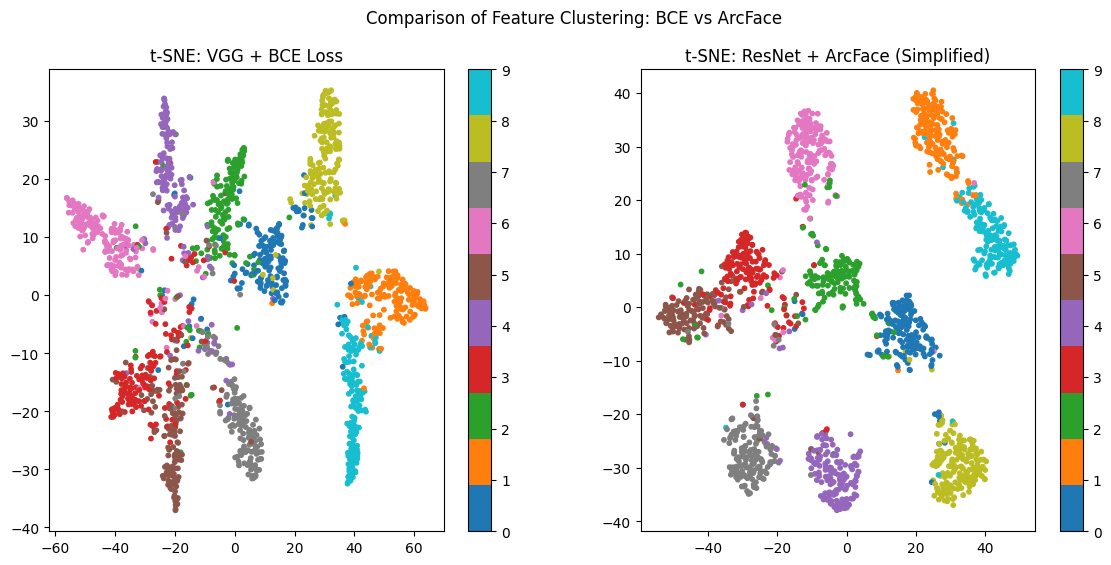

In [21]:
# Extract features
features_bce, labels_bce = extract_features(
    model_name="vgg",
    checkpoint_path="checkpoints/vgg_epoch_4.pth"
)

features_arc, labels_arc = extract_features(
    model_name="resnet",
    checkpoint_path="checkpoints/resnet_epoch_4.pth"
)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

features_bce_2d = tsne.fit_transform(features_bce)
features_arc_2d = tsne.fit_transform(features_arc)

# Plot side-by-side
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.scatter(features_bce_2d[:,0], features_bce_2d[:,1], c=labels_bce, cmap="tab10", s=10)
plt.title("t-SNE: VGG + BCE Loss")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(features_arc_2d[:,0], features_arc_2d[:,1], c=labels_arc, cmap="tab10", s=10)
plt.title("t-SNE: ResNet + ArcFace (Simplified)")
plt.colorbar()

plt.suptitle("Comparison of Feature Clustering: BCE vs ArcFace")
plt.show()


## Conclusion

Using t-SNE, we visualized the deep features learned by CNN models trained with different loss functions on CIFAR-10.  
Compared to BCE loss, the **ArcFace-style loss produces more discriminative and well-separated feature clusters** in the embedding space.

This experiment shows that the choice of loss function affects not only the final accuracy but also the **structure and quality of learned feature representations**.

Author - U23AI065
